In [21]:
# The hardest part of a Trading Strategy/Machine Learning is minimizing Overfitting. 

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score # pip install scikit-learn
import yfinance_fix

In [22]:
TICKER = "SPY"
INTERVAL = "1d"
PERIOD = "730d" if INTERVAL == "1h" else "max"

#   MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
#   MFI
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 
#   BB
BB_LENGTH = 20
STD_DEV = 2
#   RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

STRATEGY = ['Volume_Change', 'Close_Change' , 'High_Change', 'Low_Change', 'Open_Change', "MACD_HIST", "MFI", "BB", "RSI"]
SHIFT_RANGE = range(1, 120)
SHIFT = 1
OPTIMAL_SHIFT = None
LOOKBACK = 10000

# Train Test Split
TRAIN_SIZE = .7

# --- (1) Daten herunterladen ---

def get_data(ticker=TICKER, interval=INTERVAL, lookback=LOOKBACK):
    df = yf.download(ticker, session=yfinance_fix.chrome_session, interval = interval, period = PERIOD)
    # WICHTIG: Prüfen, ob überhaupt Daten da sind!
    if df.empty:
        print(f"WARNUNG: Keine Daten für {ticker} erhalten!")
        return df # Gibt leeren DF zurück, damit main() das abfangen kann
    df.columns = df.columns.get_level_values(0)
    df = df.reset_index(drop=True)

    # Adding Price Changes 
    for c in df.columns:
        df[f"{c}_Change"] = df[f"{c}"].pct_change() * 100

    # Only return the subset of data you are interested in
    subset = df.iloc[-lookback:,:]
    plt.figure()
    plt.plot(subset["Close"])
    plt.title(f"Price Movements for {ticker} during Study")
    
    return df.iloc[-lookback:, :].dropna()

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    return df

def add_MFI(df, length = MFI_LENGTH):
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):

    # Step 1: Middle Bend Column
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
    df["BB_STD"] = df["Close"].rolling(window=length).std()
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
    df["BB"] = ((df["Upper Band"] - df["Close"])/(df["Upper Band"] -   df["Lower Band"]))


    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):

    price_change = df["Close"].diff()
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
 
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()

    rs = df["avg_gain"] / df["avg_loss"]

    df["RSI"] = 100 - (100/(1+rs))


    return df.dropna()


# --- (3) Add Target ---
def add_target(df, shift=SHIFT):
    df = df.copy()
    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    df["Target"] = (df[f"Close + {shift}"] > df["Close"]) * 1
    return df.dropna().reset_index(drop=True)

# --- (4) Generate Logistic Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    subset = df[features + [target]].replace([np.inf, -np.inf], np.nan).dropna()

    if len(subset) < 10:
        raise ValueError("Too few rows after cleaning.")
    
    # To break temporal autocorrelation: shuffle all of teh columns alltogether
    # Which is only possible, because we are not creating a trading strategy. If we were, the data would have to alligned 
    # in a time series order, so latest to newest
    # 

    subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)

    X = sm.add_constant(subset[features])
    y = subset[target]
    
    model = sm.Logit(y, X).fit(disp=0)
    y_pred_prob = model.predict(X)

    df = df.loc[subset.index]
    df["Prediction"] = (y_pred_prob > 0.5).astype(int)

    return df, y, y_pred_prob

# --- (5) Analyze Logistic Regression Output ---
def add_confusion_matrix(df):
    cm = confusion_matrix(df["Target"], df["Prediction"])
    labels = ["Down (0)", "Up (1)"]

    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure()
    sns.heatmap(cm_df, annot = True, cmap = "Blues")
    plt.title("(3) Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

# ROC: Receiver Operating Characteristic Plot for Logistic Regression
def add_roc_plot(y_true, y_scores, title=f"ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_prediction_distribution(y_pred_prob):
    plt.figure()
    plt.hist(y_pred_prob, bins=50, color="grey")
    plt.title("Distribution of Logistic Predictions")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --- (6) Optimize for AUC (With Shift Range) ---

def explore_shift_auc(df_raw):
    print(f" Exploring AUC over SHIFT range for {TICKER} on {INTERVAL} interval\n")
    results = []

    for shift in SHIFT_RANGE:
        try:
            df = add_target(df_raw.copy(), shift)
            df, y, y_pred_prob = generate_regression_output(df)
            auc_score = roc_auc_score(y, y_pred_prob)
            print(f"Shift: {shift:2d} | AUC {auc_score:.4f}")
            results.append({"Shift": shift, "AUC": auc_score})
        except Exception as e:
            print(f"Shift {shift}: skipped due to error ({e})")

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
    return results_df

# --- (7) Add Train Test Split Function ---
def train_test_split(df, train_size=TRAIN_SIZE):
    # Once we have our weights and bias determined in the training set, we will be aplying this data to teh tesing set
    df = df.sample(frac=1).reset_index(drop=True)

    split = int((len(df) * .7))
    all_rows = int((len(df)))
    test_nr = int((len(df) * .3))
    print(f"Nr. of Rows (All): {all_rows}")
    print(f"Nr. of Training Rows: {split}")
    print(f"Nr. of Testing Rows: {test_nr}")

    train = df.iloc[:split, :]
    test = df.iloc[split:, :] # Our future data, not included in the training of the model
    

    return df, train, test 



[*********************100%***********************]  1 of 1 completed

Nr. of Rows (All): 8241
Nr. of Training Rows: 5768
Nr. of Testing Rows: 2472


Price,Close,High,Low,Open,Volume,Close_Change,High_Change,Low_Change,Open_Change,Volume_Change,...,Upper Band,Lower Band,BB,gain,loss,avg_gain,avg_loss,RSI,Close + 1,Target
0,92.917496,92.963159,91.821667,92.521781,221387400,0.402902,-0.642556,-0.379812,-1.009630,18.629033,...,93.631237,87.968037,0.126031,0.372864,-0.000000,0.294612,0.078815,78.894026,92.567444,0
1,89.321960,89.495226,89.134830,89.245723,43033700,0.186560,-0.715061,0.280690,-0.831742,-40.887288,...,90.953060,89.222596,0.942579,0.166328,-0.000000,0.131678,0.192569,40.610357,89.204132,0
2,36.004471,36.004471,35.515555,35.598579,479000,1.061643,0.566881,-0.310704,-0.258448,75.457875,...,35.981528,34.406598,-0.014568,0.378223,-0.000000,0.133101,0.041511,76.226538,36.041351,1
3,160.767181,160.931579,159.673917,159.706792,82782000,0.451937,-0.366456,-0.118305,-0.634219,-13.981109,...,161.752235,156.911040,0.203473,0.723297,-0.000000,0.313974,0.193183,61.908630,160.652100,0
4,76.477203,76.596035,75.474541,75.623082,224605000,1.960612,1.886993,1.752296,1.728466,28.986001,...,76.298675,72.185346,-0.043402,1.470589,-0.000000,0.428119,0.293900,59.294700,76.469780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,98.790260,99.310546,97.060681,97.967654,212828600,-0.298044,-0.514179,-1.251813,-0.747944,19.878921,...,104.181274,98.860802,1.013258,0.000000,0.295319,0.205399,0.431891,32.230006,97.496582,0
8237,105.589638,105.613068,104.902313,105.331891,139361400,0.296727,0.148086,0.501307,0.514237,2.828417,...,105.884641,100.093710,0.050942,0.312386,-0.000000,0.309626,0.101535,75.305342,105.722435,1
8238,85.595085,85.693486,84.762449,85.019807,168608400,0.381713,-0.070617,-0.089221,-0.160001,-19.642786,...,86.390307,78.337072,0.098746,0.325485,-0.000000,0.579601,0.193559,74.965181,85.572350,0
8239,111.206940,111.546016,110.497264,111.214821,120226200,-0.092100,-0.253846,-0.163864,-0.176944,-20.888410,...,112.271484,110.411315,0.572284,0.000000,0.102516,0.175737,0.162218,52.000000,111.112335,0


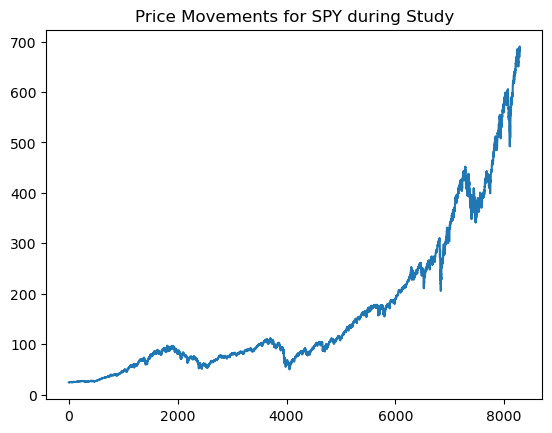

In [23]:
def make_dataset():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df, train, test = train_test_split(df)

    return df, train, test 

df, train, test = make_dataset()
df


 Exploring AUC over SHIFT range for SPY on 1d interval

Shift:  1 | AUC 0.5422
Shift:  2 | AUC 0.5296
Shift:  3 | AUC 0.5544
Shift:  4 | AUC 0.5440
Shift:  5 | AUC 0.5415
Shift:  6 | AUC 0.5381
Shift:  7 | AUC 0.5365
Shift:  8 | AUC 0.5407
Shift:  9 | AUC 0.5490
Shift: 10 | AUC 0.5494
Shift: 11 | AUC 0.5343
Shift: 12 | AUC 0.5359
Shift: 13 | AUC 0.5569
Shift: 14 | AUC 0.5409
Shift: 15 | AUC 0.5505
Shift: 16 | AUC 0.5450
Shift: 17 | AUC 0.5488
Shift: 18 | AUC 0.5295
Shift: 19 | AUC 0.5369
Shift: 20 | AUC 0.5428
Shift: 21 | AUC 0.5456
Shift: 22 | AUC 0.5391
Shift: 23 | AUC 0.5285
Shift: 24 | AUC 0.5530
Shift: 25 | AUC 0.5467
Shift: 26 | AUC 0.5540
Shift: 27 | AUC 0.5340
Shift: 28 | AUC 0.5373
Shift: 29 | AUC 0.5320
Shift: 30 | AUC 0.5373
Shift: 31 | AUC 0.5486
Shift: 32 | AUC 0.5412
Shift: 33 | AUC 0.5475
Shift: 34 | AUC 0.5326
Shift: 35 | AUC 0.5324
Shift: 36 | AUC 0.5300
Shift: 37 | AUC 0.5382
Shift: 38 | AUC 0.5479
Shift: 39 | AUC 0.5455
Shift: 40 | AUC 0.5353
Shift: 41 | AUC 0.5573
S

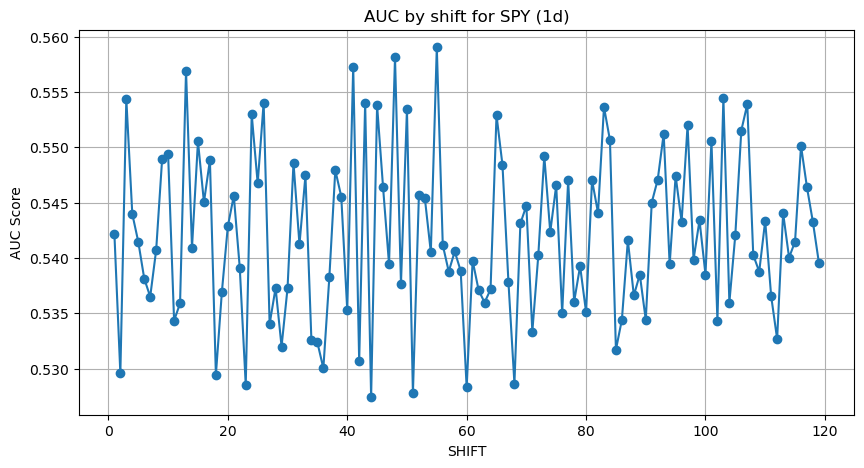


 Optimal SHIFT based on AUC: 55

 Running Final Model Analysis with SHIFT = 55


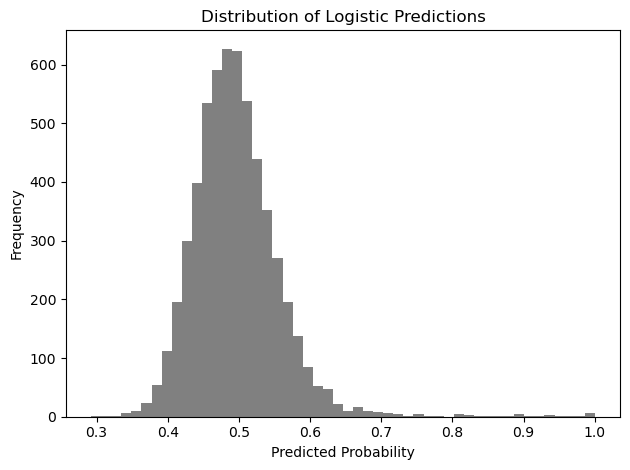

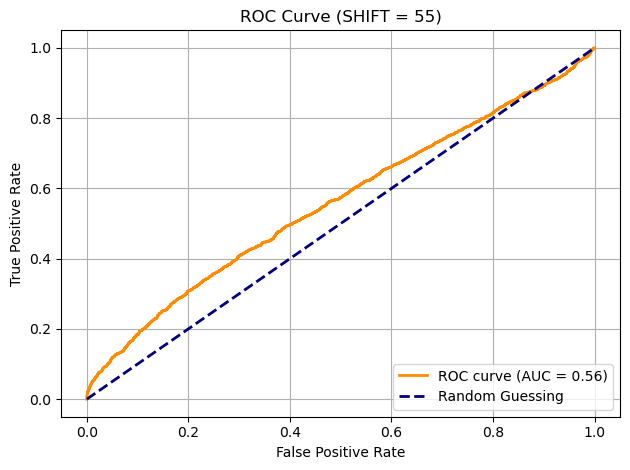

,Shift,AUC
0,55,0.559036
1,48,0.558114
2,41,0.557289
3,13,0.556922
4,103,0.554418
...,...,...
114,68,0.528665
115,23,0.528541
116,60,0.528328
117,51,0.527769


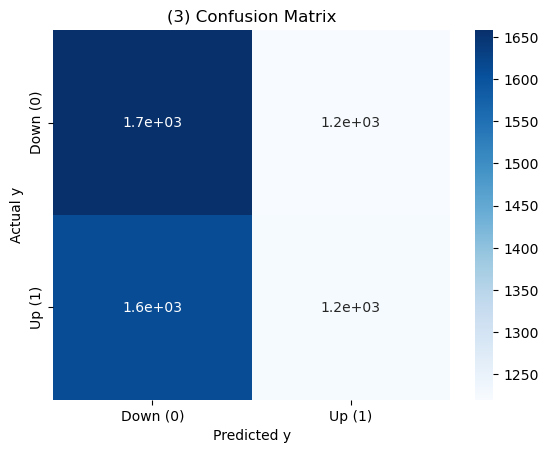

In [24]:
# Applying the Regression Output Function only to the training Dataset

def study_dataset(df):
    global OPTIMAL_SHIFT

    # Explore AUC over multiple shifts
    results_df = explore_shift_auc(df)
    plot_df = results_df.sort_values(by="Shift")

    # Plot AUC vs. SHIFT 
    plt.figure(figsize=(10,5))
    plt.plot(plot_df["Shift"], plot_df["AUC"], marker="o")
    plt.title(f"AUC by shift for {TICKER} ({INTERVAL})")
    plt.xlabel("SHIFT")
    plt.ylabel("AUC Score")
    plt.grid(True)
    plt.show()

    # What this graphy could possibly guide us is:
    # I would place a trade on the minutely timeframe, I would want to hold my trade for {Optimal Shift} Min/Hour/Days
    # We want to find/see something closer to 0.60, becuase if our cutoff is 0.5, then we are just randomly seeing it 

    # Set optimal shift globally for future studies
    OPTIMAL_SHIFT = int(results_df.iloc[0]["Shift"])
    print(f"\n Optimal SHIFT based on AUC: {OPTIMAL_SHIFT}")

    # Final Study with Optimal shift
    print(f"\n Running Final Model Analysis with SHIFT = {OPTIMAL_SHIFT}")
    df_final = add_target(df.copy(), shift=OPTIMAL_SHIFT)
    df_final, y_final, y_pred_prob = generate_regression_output(df_final)

    plot_prediction_distribution(y_pred_prob)
    add_roc_plot(y_final, y_pred_prob, title=f"ROC Curve (SHIFT = {OPTIMAL_SHIFT})")
    add_confusion_matrix(df_final)

    return df, results_df 

df, results_df = study_dataset(train)
results_df 